# Project Topic
Develop an algorithm to identify cancer in small image patches taken from larger digital pathology scans. 

# Project Goal
This project centers on the application of Convolutional Neural Networks (CNN) to Histopathologic Cancer Detection, a critical task in medical diagnostics. Histopathologic analysis involves examining tissue samples under a microscope to identify signs of disease, such as cancer. The use of CNN in this domain aims to automate and enhance the accuracy of detecting cancer cells in histopathology images.

The challenge at hand is to develop a CNN model capable of discerning subtle patterns and features in histopathologic slides that are indicative of cancer. This is a nuanced task, given the complexity of tissue structures and the subtle variations that distinguish benign from malignant cells.

# Data Source
In this dataset, We are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

Total no of image is 220,025

Data Source
https://www.kaggle.com/competitions/histopathologic-cancer-detection


# Explaratory Data Analysis and Cleanup

In this section, we'll try to explore the data as well as prepare it to be used for the models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os

BASE_DIR = '/kaggle/input/histopathologic-cancer-detection/'

train_df = pd.read_csv(BASE_DIR + 'train_labels.csv')
train_df.head()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [57]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


The training CSV file contains a total of **220,025** sets of IDs and labels.

The IDs here correspond to the name of the image file in the adjacent folder, while the labels indicate whether the image with given ID is of a cancerous cell or not.

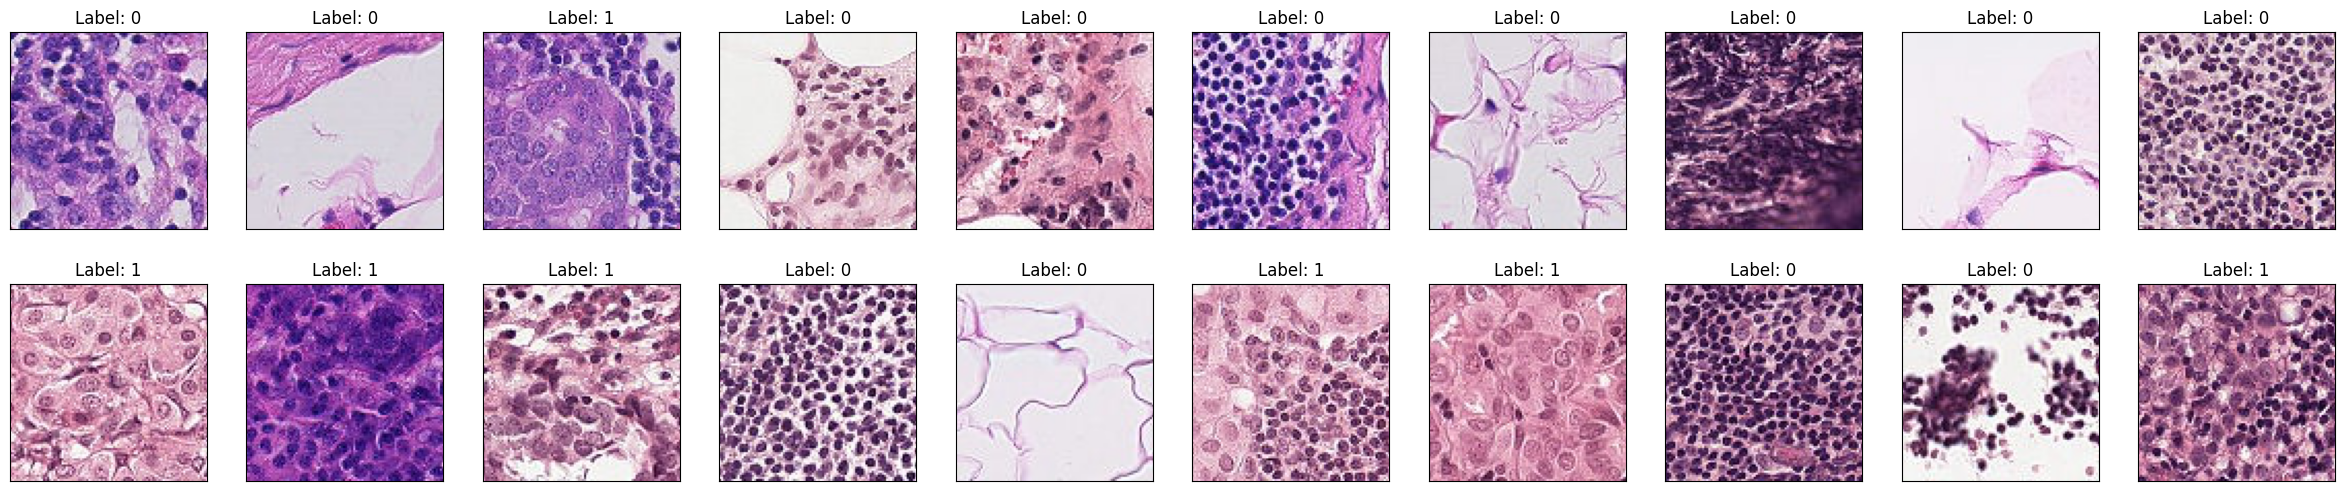

In [2]:
fig = plt.figure(figsize=(30, 6))
train_imgs = os.listdir(BASE_DIR+"train")
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(BASE_DIR+"train/" + img)
    plt.imshow(im)
    label = train_df.loc[train_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {label}')

We can see some random images here from the training set. It is very difficult to tell which ones are cancerous and which ones aren't without the labels.

In [3]:
np.array(im).shape

(96, 96, 3)

<Axes: ylabel='count'>

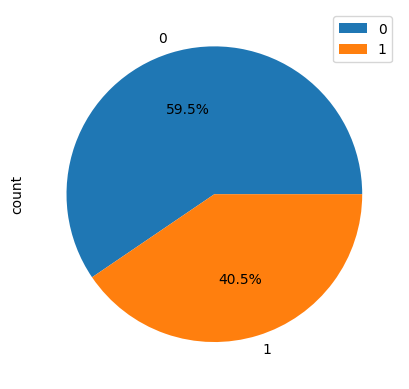

In [4]:
train_df['label'].value_counts().plot(kind='pie', legend=True, autopct='%1.1f%%')

It appears like the data provided for training purposes contains 60% values with label 0 and 40% with 1.

Since this project is going to use keras, we will need to prepare a keras dataset. Keras utils method `image_dataset_from_directory` does not support tif files at the time of this writing. As such, the files need to be converted to something supported by the method.

In [5]:
def convert_image(image_file, label=0, with_label=True, subset='train'):
    image_name = image_file.split('.')[0]
    
    if with_label:
#         label = train_df[train_df['id'] == image_name]['label'].iloc[0]
        output_dir = f'png/{subset}/{label}'
    else:
        output_dir = f'png/{subset}'

    os.makedirs(output_dir, exist_ok=True)

    output_path = f'{output_dir}/{image_name}.png'
    if not os.path.exists(output_path):
        with Image.open(BASE_DIR + f'{subset}/{image_file}') as tiff_img:
            png = tiff_img.convert("RGB")
            png.save(output_path)

In [6]:
import multiprocessing
from tqdm import tqdm

def convert_image_wrapper(args):
    return convert_image(*args)

def process_images(image_files, labels=[], with_label=True, subset='train'):
    num_processes = multiprocessing.cpu_count()
    
    with multiprocessing.Pool(processes=num_processes) as pool:
        tasks = [(filename, labels[index] if with_label else 0, with_label, subset) for index, filename in enumerate(image_files)]
        for _ in tqdm(pool.imap_unordered(convert_image_wrapper, tasks), total=len(tasks)):
            pass

In [7]:
# This process takes some time (20+ minutes)
process_images((train_df['id']+'.tif').values.tolist(), labels=train_df['label'].values.tolist())

100%|██████████| 220025/220025 [09:15<00:00, 395.84it/s]


In [8]:
process_images(os.listdir(BASE_DIR+"test"), with_label=False, subset='test')

100%|██████████| 57458/57458 [02:46<00:00, 345.06it/s]


Now we should have PNG equivalent of the training data separated into different folders based on their classes. We should be able to load the datasets.

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/working/png/train', 
                                                            label_mode='binary',
                                                            image_size=(96,96), 
                                                            seed=42,
                                                            validation_split=0.2,
                                                            subset='training',
                                                            batch_size=128)

val_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/working/png/train', 
                                                            label_mode='binary',
                                                            image_size=(96,96), 
                                                            seed=42,
                                                            validation_split=0.2,
                                                            subset='validation',
                                                            batch_size=128)


Found 220025 files belonging to 2 classes.
Using 176020 files for training.
Found 220025 files belonging to 2 classes.
Using 44005 files for validation.


In [10]:
test_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/working/png/test',
                                                            label_mode=None,
                                                            image_size=(96,96),
                                                            shuffle=False,
                                                            batch_size=1)

Found 57458 files belonging to 1 classes.


# Developing the Model

Since we have the datasets ready, we can continue with model development.

I decided to first trying to build a completely custom model. The model consists of three convolutional layers for feature extraction followed by three dense layers for classification. 

The convolutional layers have max pooling in between them. 

The dense layers utilize the ReLU activation function, except for the output layer which uses sigmoid.

In [24]:
from tensorflow.keras import layers, models

model = tf.keras.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(96,96,3)))
model.add(layers.Conv2D(32, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (2, 2), strides=(2,2), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        416       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 64)        8256      
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 128)         32896     
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                      

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [36]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
1376/1376 [==============================] - 75s 51ms/step - loss: 0.4523 - accuracy: 0.7900 - val_loss: 0.3903 - val_accuracy: 0.8281
Epoch 2/10
1376/1376 [==============================] - 71s 51ms/step - loss: 0.3747 - accuracy: 0.8354 - val_loss: 0.3646 - val_accuracy: 0.8431
Epoch 3/10
1376/1376 [==============================] - 70s 51ms/step - loss: 0.3420 - accuracy: 0.8508 - val_loss: 0.3541 - val_accuracy: 0.8494
Epoch 4/10
1376/1376 [==============================] - 71s 52ms/step - loss: 0.3121 - accuracy: 0.8666 - val_loss: 0.3297 - val_accuracy: 0.8587
Epoch 5/10
1376/1376 [==============================] - 71s 51ms/step - loss: 0.2878 - accuracy: 0.8790 - val_loss: 0.3012 - val_accuracy: 0.8746
Epoch 6/10
1376/1376 [==============================] - 71s 51ms/step - loss: 0.2666 - accuracy: 0.8891 - val_loss: 0.3736 - val_accuracy: 0.8453
Epoch 7/10
1376/1376 [==============================] - 70s 51ms/step - loss: 0.2462 - accuracy: 0.8988 - val_loss: 0.3024 -

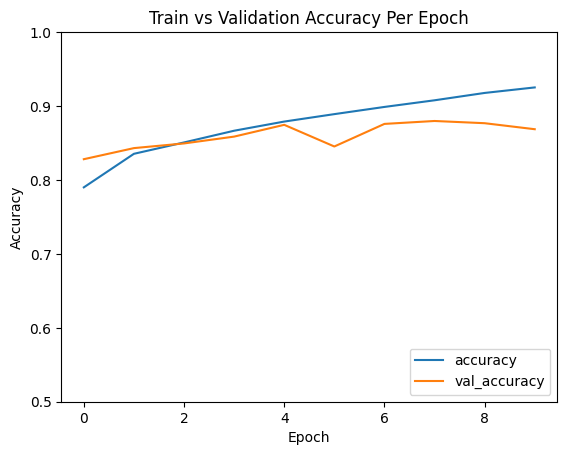

In [38]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Train vs Validation Accuracy Per Epoch')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Train vs Validation Loss Per Epoch')

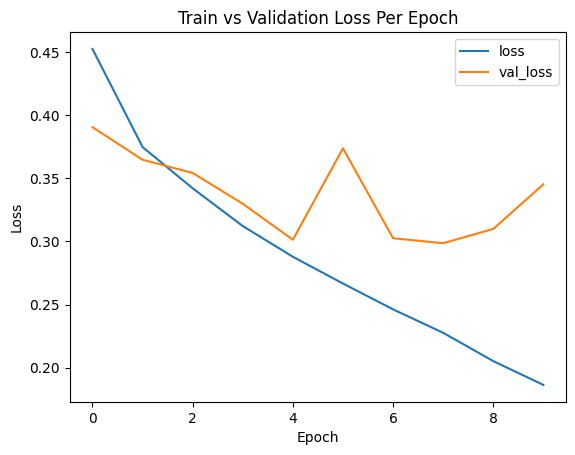

In [39]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss Per Epoch')

With __86%__ accuracy in the validation set, the model performed reasonably well. Based on the graphs, we can see that the model might be overfitting after the fourth epoch, as validation loss and accuracy both started to decrease from that point. 

In [40]:
test_imgs = os.listdir("/kaggle/working/png/test")
model1_pred_df = pd.DataFrame(columns=['id', 'label'])
test_imgs=sorted(test_imgs)

In [41]:
predictions = model.predict(test_dataset)

57458/57458 [==============================] - 101s 2ms/step


In [42]:
model1_pred_df['id'] = [filename.split('.')[0] for filename in test_imgs]
model1_pred_df['label'] = np.round(predictions.flatten()).astype('int')
model1_pred_df

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,0


In [43]:
model1_pred_df.to_csv('custom_model_predictions.csv', index=False)

As a second approach, I ventured to developing a model with ImageNet as the base model. Using ImageNet's weights, the dense layers were applied similar to the custom model.

In [25]:
from tensorflow.keras.applications import VGG16
base_model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 32)           864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 32)           0         ['bn_Conv1[0

In [47]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

inputs = tf.keras.Input(shape=(96, 96, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
outputs = prediction_layer(x)
imagenet_model = tf.keras.Model(inputs, outputs)
imagenet_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 64)                81984     
                                                                 
 dense_16 (Dense)            (None, 32)                2080

In [50]:
base_learning_rate = 0.001
imagenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [51]:
imagenet_history = imagenet_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
1376/1376 [==============================] - 81s 56ms/step - loss: 0.4580 - accuracy: 0.7848 - val_loss: 0.4380 - val_accuracy: 0.7955
Epoch 2/10
1376/1376 [==============================] - 77s 56ms/step - loss: 0.4488 - accuracy: 0.7899 - val_loss: 0.4347 - val_accuracy: 0.7981
Epoch 3/10
1376/1376 [==============================] - 76s 55ms/step - loss: 0.4440 - accuracy: 0.7931 - val_loss: 0.4270 - val_accuracy: 0.8025
Epoch 4/10
1376/1376 [==============================] - 77s 55ms/step - loss: 0.4409 - accuracy: 0.7947 - val_loss: 0.4268 - val_accuracy: 0.8034
Epoch 5/10
1376/1376 [==============================] - 77s 56ms/step - loss: 0.4370 - accuracy: 0.7970 - val_loss: 0.4241 - val_accuracy: 0.8041
Epoch 6/10
1376/1376 [==============================] - 76s 55ms/step - loss: 0.4348 - accuracy: 0.7977 - val_loss: 0.4361 - val_accuracy: 0.7978
Epoch 7/10
1376/1376 [==============================] - 77s 56ms/step - loss: 0.4325 - accuracy: 0.7999 - val_loss: 0.4205 -

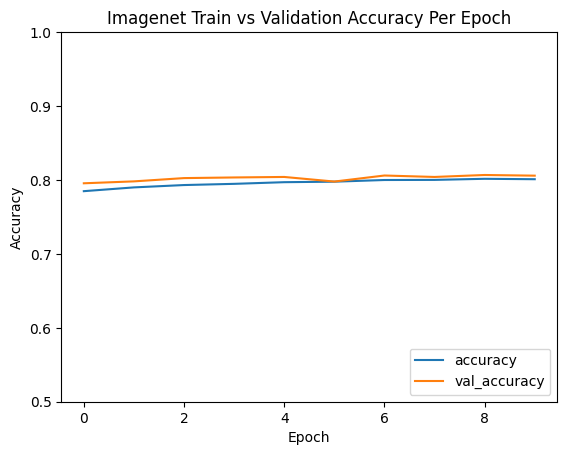

In [52]:
plt.plot(imagenet_history.history['accuracy'], label='accuracy')
plt.plot(imagenet_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.title('Imagenet Train vs Validation Accuracy Per Epoch')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Imagenet Train vs Validation Loss Per Epoch')

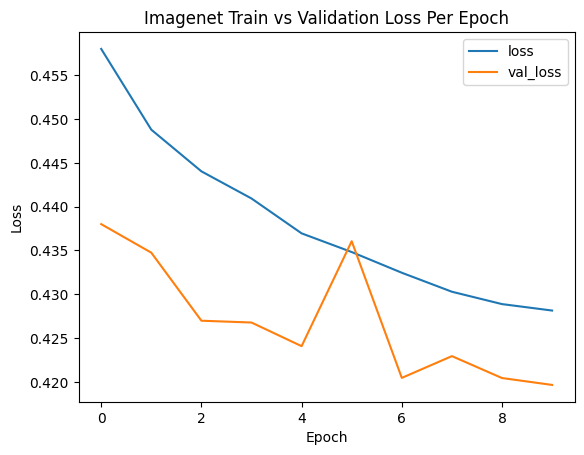

In [53]:
plt.plot(imagenet_history.history['loss'], label='loss')
plt.plot(imagenet_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Imagenet Train vs Validation Loss Per Epoch')

Interestingly, the accuracy for both validation and training data remained almost constant throughout the training. The loss for both steadily went down (apart from at the fifth epoch for validation where something wild happened).

Let's try predicting test results with this model.

In [54]:
model2_pred_df = pd.DataFrame(columns=['id', 'label'])
imagenet_predictions = imagenet_model.predict(test_dataset)


57458/57458 [==============================] - 317s 5ms/step


In [55]:
model2_pred_df['id'] = [filename.split('.')[0] for filename in test_imgs]
model2_pred_df['label'] = np.round(imagenet_predictions.flatten()).astype('int')
model2_pred_df

,id,label
0,00006537328c33e284c973d7b39d340809f7271b,1
1,0000ec92553fda4ce39889f9226ace43cae3364e,1
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0
4,000270442cc15af719583a8172c87cd2bd9c7746,0
...,...,...
57453,fffdd1cbb1ac0800f65309f344dd15e9331e1c53,0
57454,fffdf4b82ba01f9cae88b9fa45be103344d9f6e3,0
57455,fffec7da56b54258038b0d382b3d55010eceb9d7,0
57456,ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6,1


In [56]:
model2_pred_df.to_csv('imagenet_predictions.csv', index=False)

# Results and Analysis

The project explored two distinct CNN models for histopathologic cancer detection: a custom-built model and an ImageNet-based model. The custom model, comprising three convolutional layers with max pooling and three dense layers, achieved a validation accuracy of 86% and demonstrated potential overfitting beyond the fourth epoch. This was evident as both validation loss and accuracy began to decrease. 

In contrast, the ImageNet-based model maintained stable performance throughout training, with an unexpected fluctuation in the fifth epoch. Its stabilit is higher. 

| Model Type | Validation Accuracy | Stability | Remarks |
| -----------|---------------------|-----------|---------|
| Custom Model | 86% | Low | Overfitting after 4th epoch |
| ImageNet-Based | 80% | High | Consistent performance |


## Troubleshooting and Future Considerations

For the custom model, implementing techniques such as dropout, early stopping, or adding regularization could help mitigate overfitting. For the ImageNet-based model, exploring different architectures or fine-tuning additional layers might improve its ability to capture more complex patterns in the data.

In summary, both models provide foundational insights for histopathologic cancer detection, yet each requires specific adjustments to fully optimize their performance. Future work should focus on balancing model complexity with the ability to generalize, along with exploring systematic hyperparameter optimization strategies.

# Conclusion

In this project, we explored CNNs for histopathologic cancer detection using two models: a custom-built model and an ImageNet-based model. The custom model showed high accuracy (86%) but tended to overfit after the fourth epoch. The ImageNet-based model, while stable, achieved a lower score of 0.7855, suggesting that it might not fully capture the dataset's complexity.

No hyperparameter optimization was performed, which could be a direction for future improvement. Both models have their strengths - the custom model in accuracy and the ImageNet model in stability. This project highlights the potential of CNNs in medical imaging but also the need for balanced model design and hyperparameter tuning to enhance performance and generalization. Future efforts could focus on combining the best aspects of both models and systematic hyperparameter optimization for better cancer detection capabilities.

# References

- Cukierski, W.: *Histopathologic Cancer Detection*, Kaggle, https://kaggle.com/competitions/histopathologic-cancer-detection, 2018.
- https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview
- https://nnabla.readthedocs.io/en/latest/python/api/models/imagenet.html